In [1]:
import gensim.downloader as api

# Load the model using gensim.downloader
weight_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [2]:
from gensim.models import KeyedVectors

import torch

import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
# weight_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
import json
# Specify the path to your JSON file
json_file_path = 'NER_training_data.json'

# Read the JSON file
with open(json_file_path) as f:
    data = json.load(f)

# data
# print(len(data))

# Specify the path to your JSON file
json_file_path = 'NER_validation_data.json'

# Read the JSON file
with open(json_file_path) as f:
    validation_data = json.load(f)



In [5]:

for key, value in data.items():
    word = value['text'].split()
    labels = value['labels']
    new_labels = []
    new_word = []
    for i in range(len(word)):
        if(word[i]==''):
            print(word)
            continue
        # new_labels.append(labels[i])
        new_word.append(word[i])
    # value['labels'] = new_labels
    value['word'] = new_word


In [6]:
label_to_idx = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6,
                    'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12,
                    'B_WITNESS': 13, 'I_WITNESS': 14, 'B_PRECEDENT': 15, 'I_PRECEDENT': 16, 'B_DATE': 17, 'I_DATE': 18,
                    'B_PETITIONER': 19, 'I_PETITIONER': 20, 'B_GPE' : 21, 'I_GPE': 22, 'B_RESPONDENT': 23, 'I_RESPONDENT': 24,
                    'B_COURT': 25, 'I_COURT': 26}

In [7]:
sentence_for_training = []
tags_for_training = []
X_train=[]
y_train=[]

word_to_idx={}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    T_idx = []
    for i in word:
        index = word_to_idx.get(i, 0)
        T_idx.append(index)
    X_train.append(torch.tensor(T_idx))
    y_train.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_train = pad_sequence(X_train, batch_first=True, padding_value=0)
y_train = pad_sequence(y_train, batch_first=True, padding_value=0)

print(X_train.shape)

torch.Size([7545, 70])


In [8]:
max_len=max([len(i) for i in X_train])
X_validation=[]
y_validation=[]

word_to_idx={}
# word_to_idx = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in validation_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    # text_indices = [word_to_idx.get(word, 0) for word in word]
    X_validation.append(torch.tensor(text_indices))
    y_validation.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_validation = pad_sequence(X_validation, batch_first=True, padding_value=0)
y_validation = pad_sequence(y_validation, batch_first=True, padding_value=0)

In [9]:
class rnnTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(rnnTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embedding = self.embedding(sentence)
        rnn_out_embed, _ = self.rnn(embedding)
        tag_space_rnn = self.linear(rnn_out_embed)
        return tag_space_rnn

In [10]:
# Define hyperparameters
input_size = len(word_to_idx) + 1  # Add 1 for padding token
embedding_dim = weight_model.vector_size  # Should match the dimensionality of your word vectors
hidden_size = 64
vocab_size = len(weight_model.index_to_key)

output_size = 27

In [11]:
model = rnnTagger(embedding_dim, hidden_size, vocab_size, output_size, torch.FloatTensor(weight_model.vectors))

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Decrease batch size
val_dataset = TensorDataset(X_validation, y_validation)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)  # Decrease batch size

In [14]:
# Train the model
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

In [16]:
num_epochs = 100
predicted_labels1 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_all_preds = []
    train_all_labels = []
    for text, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(text)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 2)
        train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
        predicted_labels1.extend(predicted.view(-1).cpu().numpy().tolist())
        train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    val_loss = 0
    val_all_preds = []
    val_all_labels = []
    with torch.no_grad():
        model.eval()
        for text, labels in val_loader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, output_size), labels.view(-1))
            val_loss += loss.item()


            _, predicted = torch.max(outputs, 2)
            val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
    val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Macro-F1: {val_f1:.4f}")


Epoch 1/100, Training Loss: 7.9039, Training Macro-F1: 0.4601, Validation Loss: 1.9357, Validation Macro-F1: 0.4104
Epoch 2/100, Training Loss: 7.8346, Training Macro-F1: 0.4635, Validation Loss: 1.9664, Validation Macro-F1: 0.4075
Epoch 3/100, Training Loss: 7.8197, Training Macro-F1: 0.4660, Validation Loss: 1.9858, Validation Macro-F1: 0.3992
Epoch 4/100, Training Loss: 7.7627, Training Macro-F1: 0.4670, Validation Loss: 1.9885, Validation Macro-F1: 0.4172
Epoch 5/100, Training Loss: 7.6767, Training Macro-F1: 0.4710, Validation Loss: 2.0228, Validation Macro-F1: 0.4098
Epoch 6/100, Training Loss: 7.6844, Training Macro-F1: 0.4701, Validation Loss: 1.9331, Validation Macro-F1: 0.4191
Epoch 7/100, Training Loss: 7.5521, Training Macro-F1: 0.4734, Validation Loss: 1.9963, Validation Macro-F1: 0.4090
Epoch 8/100, Training Loss: 7.5176, Training Macro-F1: 0.4770, Validation Loss: 1.9553, Validation Macro-F1: 0.4139
Epoch 9/100, Training Loss: 7.4985, Training Macro-F1: 0.4782, Validatio

In [17]:
# Specify the path to your JSON file
json_file_path = 'NER_test_data.json'

# Read the JSON file
with open(json_file_path) as f:
    test_data = json.load(f)


In [18]:
X_test=[]
y_test=[]

for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in test_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    X_test.append(torch.tensor(text_indices))
    y_test.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_test = pad_sequence(X_test, batch_first=True, padding_value=0)
y_test = pad_sequence(y_test, batch_first=True, padding_value=0)

Test Loss: 0.2474, Test Macro-F1: 0.4442


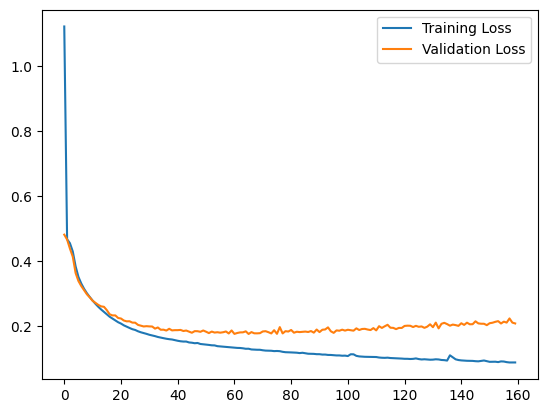

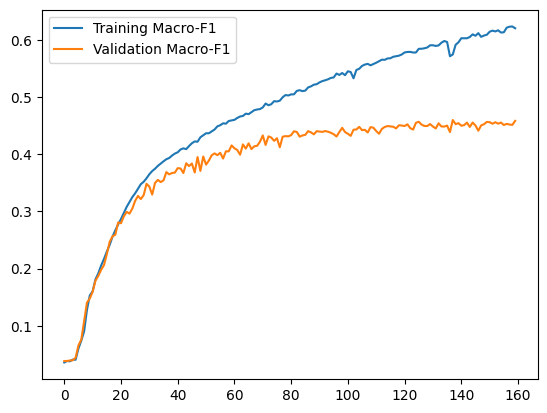

In [19]:
def evaluate_model(model, dataloader, criterion, tagset_size):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, labels in dataloader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, macro_f1
# Evaluate on the test dataset
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)  # Decrease batch size

test_loss, test_f1 = evaluate_model(model, test_loader, criterion, output_size)
print(f"Test Loss: {test_loss:.4f}, Test Macro-F1: {test_f1:.4f}")


# Plot the training and validation loss
def showresults():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    # save the graph
    plt.savefig('loss_NER_RNN.png')
    plt.show()

    plt.plot(train_f1s, label='Training Macro-F1')
    plt.plot(val_f1s, label='Validation Macro-F1')
    plt.legend()
    # save the graph
    plt.savefig('f1_NER_RNN.png')
    plt.show()
showresults()

**LSTM**

In [20]:
from gensim.models import KeyedVectors

import torch

import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [21]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [22]:
#  import lstm libraries of torch
from torch.nn import LSTM


In [23]:
import json
# Specify the path to your JSON file
json_file_path = 'NER_training_data.json'

# Read the JSON file
with open(json_file_path) as f:
    data = json.load(f)

# data
# print(len(data))

# Specify the path to your JSON file
json_file_path = 'NER_validation_data.json'

# Read the JSON file
with open(json_file_path) as f:
    validation_data = json.load(f)



In [24]:

for key, value in data.items():
    word = value['text'].split()
    labels = value['labels']
    new_labels = []
    new_word = []
    for i in range(len(word)):
        if(word[i]==''):
            print(word)
            continue
        # new_labels.append(labels[i])
        new_word.append(word[i])
    # value['labels'] = new_labels
    value['word'] = new_word


In [25]:
label_to_idx = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6,
                    'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12,
                    'B_WITNESS': 13, 'I_WITNESS': 14, 'B_PRECEDENT': 15, 'I_PRECEDENT': 16, 'B_DATE': 17, 'I_DATE': 18,
                    'B_PETITIONER': 19, 'I_PETITIONER': 20, 'B_GPE' : 21, 'I_GPE': 22, 'B_RESPONDENT': 23, 'I_RESPONDENT': 24,
                    'B_COURT': 25, 'I_COURT': 26}

In [26]:
sentence_for_training = []
tags_for_training = []
X_train=[]
y_train=[]

word_to_idx={}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    T_idx = []
    for i in word:
        index = word_to_idx.get(i, 0)
        T_idx.append(index)
    X_train.append(torch.tensor(T_idx))
    y_train.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_train = pad_sequence(X_train, batch_first=True, padding_value=0)
y_train = pad_sequence(y_train, batch_first=True, padding_value=0)

print(X_train.shape)

torch.Size([7545, 70])


In [27]:
max_len=max([len(i) for i in X_train])
X_validation=[]
y_validation=[]

word_to_idx={}
# word_to_idx = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in validation_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    # text_indices = [word_to_idx.get(word, 0) for word in word]
    X_validation.append(torch.tensor(text_indices))
    y_validation.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_validation = pad_sequence(X_validation, batch_first=True, padding_value=0)
y_validation = pad_sequence(y_validation, batch_first=True, padding_value=0)

In [28]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embedding = self.embedding(sentence)
        lstm_out, _ = self.lstm(embedding)
        tag_space_lstm = self.linear(lstm_out)
        return tag_space_lstm

In [29]:
# Define hyperparameters
input_size = len(word_to_idx) + 1  # Add 1 for padding token
embedding_dim = weight_model.vector_size  # Should match the dimensionality of your word vectors
hidden_size = 64
vocab_size = len(weight_model.index_to_key)

output_size = 27

In [30]:
model = LSTM(embedding_dim, hidden_size, vocab_size, output_size, torch.FloatTensor(weight_model.vectors))

In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [32]:
# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # Decrease batch size
val_dataset = TensorDataset(X_validation, y_validation)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)  # Decrease batch size

In [33]:
# Train the model
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

In [ ]:
num_epochs = 160
predicted_labels1 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_all_preds = []
    train_all_labels = []
    for text, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(text)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 2)
        train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
        predicted_labels1.extend(predicted.view(-1).cpu().numpy().tolist())
        train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    val_loss = 0
    val_all_preds = []
    val_all_labels = []
    with torch.no_grad():
        model.eval()
        for text, labels in val_loader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, output_size), labels.view(-1))
            val_loss += loss.item()


            _, predicted = torch.max(outputs, 2)
            val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
    val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Macro-F1: {val_f1:.4f}")


Epoch 1/160, Training Loss: 35.5936, Training Macro-F1: 0.0387, Validation Loss: 3.0392, Validation Macro-F1: 0.0385
Epoch 2/160, Training Loss: 14.3753, Training Macro-F1: 0.0385, Validation Loss: 2.7092, Validation Macro-F1: 0.0385
Epoch 3/160, Training Loss: 13.4998, Training Macro-F1: 0.0385, Validation Loss: 2.6757, Validation Macro-F1: 0.0385
Epoch 4/160, Training Loss: 12.3295, Training Macro-F1: 0.0386, Validation Loss: 2.3610, Validation Macro-F1: 0.0403
Epoch 5/160, Training Loss: 11.2404, Training Macro-F1: 0.0480, Validation Loss: 2.1435, Validation Macro-F1: 0.0569
Epoch 6/160, Training Loss: 10.2150, Training Macro-F1: 0.0709, Validation Loss: 1.9904, Validation Macro-F1: 0.0777
Epoch 7/160, Training Loss: 9.4364, Training Macro-F1: 0.0885, Validation Loss: 1.8024, Validation Macro-F1: 0.0950
Epoch 8/160, Training Loss: 8.8825, Training Macro-F1: 0.1042, Validation Loss: 1.7279, Validation Macro-F1: 0.1067
Epoch 9/160, Training Loss: 8.4759, Training Macro-F1: 0.1224, Val

In [ ]:
# Specify the path to your JSON file
json_file_path = 'NER_test_data.json'

# Read the JSON file
with open(json_file_path) as f:
    test_data = json.load(f)


In [ ]:
X_test=[]
y_test=[]

for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in test_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    X_test.append(torch.tensor(text_indices))
    y_test.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_test = pad_sequence(X_test, batch_first=True, padding_value=0)
y_test = pad_sequence(y_test, batch_first=True, padding_value=0)

Test Loss: 0.2790, Test Macro-F1: 0.4493


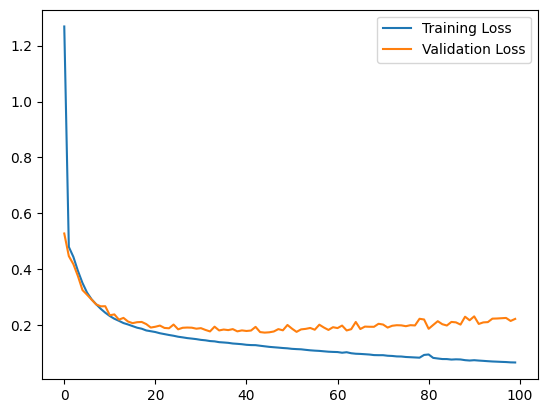

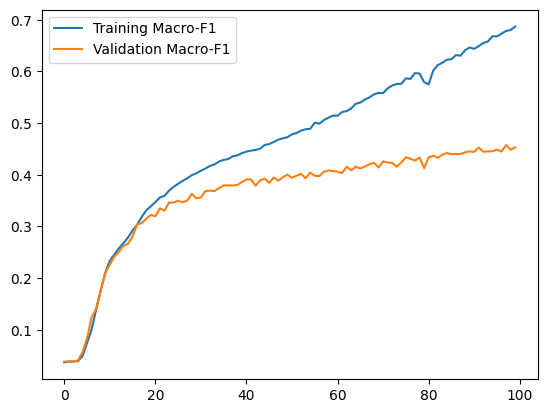

In [ ]:
def evaluate_model(model, dataloader, criterion, tagset_size):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, labels in dataloader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, macro_f1
# Evaluate on the test dataset
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)  # Decrease batch size

test_loss, test_f1 = evaluate_model(model, test_loader, criterion, output_size)
print(f"Test Loss: {test_loss:.4f}, Test Macro-F1: {test_f1:.4f}")

# Plot the training and validation loss
def showresults():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    # save the graph
    plt.savefig('loss_NER_LSTM.png')
    plt.show()

    plt.plot(train_f1s, label='Training Macro-F1')
    plt.plot(val_f1s, label='Validation Macro-F1')
    plt.legend()
    # save the graph
    plt.savefig('f1_NER_LSTM.png')
    plt.show()
showresults()

In [ ]:
#  save the model
torch.save(model.state_dict(), 'NER_LSTM.pth')

#  load the model
model = LSTM(embedding_dim, hidden_size, vocab_size, output_size, torch.FloatTensor(weight_model.vectors))
model.load_state_dict(torch.load('NER_LSTM.pth'))

<All keys matched successfully>

**GRU**

In [ ]:
from gensim.models import KeyedVectors

import torch

import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [ ]:
import json
# Specify the path to your JSON file
json_file_path = 'NER_training_data.json'

# Read the JSON file
with open(json_file_path) as f:
    data = json.load(f)

# data
# print(len(data))

# Specify the path to your JSON file
json_file_path = 'NER_validation_data.json'

# Read the JSON file
with open(json_file_path) as f:
    validation_data = json.load(f)



In [ ]:

for key, value in data.items():
    word = value['text'].split()
    labels = value['labels']
    new_labels = []
    new_word = []
    for i in range(len(word)):
        if(word[i]==''):
            print(word)
            continue
        # new_labels.append(labels[i])
        new_word.append(word[i])
    # value['labels'] = new_labels
    value['word'] = new_word


In [ ]:
label_to_idx = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6,
                    'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12,
                    'B_WITNESS': 13, 'I_WITNESS': 14, 'B_PRECEDENT': 15, 'I_PRECEDENT': 16, 'B_DATE': 17, 'I_DATE': 18,
                    'B_PETITIONER': 19, 'I_PETITIONER': 20, 'B_GPE' : 21, 'I_GPE': 22, 'B_RESPONDENT': 23, 'I_RESPONDENT': 24,
                    'B_COURT': 25, 'I_COURT': 26}

In [ ]:
sentence_for_training = []
tags_for_training = []
X_train=[]
y_train=[]

word_to_idx={}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    T_idx = []
    for i in word:
        index = word_to_idx.get(i, 0)
        T_idx.append(index)
    X_train.append(torch.tensor(T_idx))
    y_train.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_train = pad_sequence(X_train, batch_first=True, padding_value=0)
y_train = pad_sequence(y_train, batch_first=True, padding_value=0)

print(X_train.shape)

torch.Size([7545, 70])


In [ ]:
max_len=max([len(i) for i in X_train])
X_validation=[]
y_validation=[]

word_to_idx={}
# word_to_idx = {word: idx + 1 for idx, word in enumerate(word_vectors.index_to_key)}
for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in validation_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    # text_indices = [word_to_idx.get(word, 0) for word in word]
    X_validation.append(torch.tensor(text_indices))
    y_validation.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_validation = pad_sequence(X_validation, batch_first=True, padding_value=0)
y_validation = pad_sequence(y_validation, batch_first=True, padding_value=0)

In [ ]:
class rnnTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(rnnTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embedding = self.embedding(sentence)
        rnn_out_embed, _ = self.rnn(embedding)
        tag_space_rnn = self.linear(rnn_out_embed)
        return tag_space_rnn

In [ ]:
# Define hyperparameters
input_size = len(word_to_idx) + 1  # Add 1 for padding token
embedding_dim = weight_model.vector_size  # Should match the dimensionality of your word vectors
hidden_size = 64
vocab_size = len(weight_model.index_to_key)

output_size = 27

In [ ]:
model = rnnTagger(embedding_dim, hidden_size, vocab_size, output_size, torch.FloatTensor(weight_model.vectors))

NameError: name 'RNNTagger' is not defined

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Prepare data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Decrease batch size
val_dataset = TensorDataset(X_validation, y_validation)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)  # Decrease batch size

In [ ]:
# Train the model
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

In [ ]:
num_epochs = 160
predicted_labels1 = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_all_preds = []
    train_all_labels = []
    for text, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(text)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 2)
        train_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
        predicted_labels1.extend(predicted.view(-1).cpu().numpy().tolist())
        train_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    val_loss = 0
    val_all_preds = []
    val_all_labels = []
    with torch.no_grad():
        model.eval()
        for text, labels in val_loader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, output_size), labels.view(-1))
            val_loss += loss.item()


            _, predicted = torch.max(outputs, 2)
            val_all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            val_all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_f1 = f1_score(train_all_labels, train_all_preds, average='macro')
    val_f1 = f1_score(val_all_labels, val_all_preds, average='macro')
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss:.4f}, Training Macro-F1: {train_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation Macro-F1: {val_f1:.4f}")


Epoch 1/60, Training Loss: 73.4622, Validation Loss: 5.2877, Training Macro-F1: 0.0348, Validation Macro-F1: 0.0385
Epoch 2/60, Training Loss: 27.8818, Validation Loss: 5.1541, Training Macro-F1: 0.0385, Validation Macro-F1: 0.0385
Epoch 3/60, Training Loss: 27.2887, Validation Loss: 5.0513, Training Macro-F1: 0.0375, Validation Macro-F1: 0.0395
Epoch 4/60, Training Loss: 26.5449, Validation Loss: 4.8503, Training Macro-F1: 0.0377, Validation Macro-F1: 0.0399
Epoch 5/60, Training Loss: 24.6086, Validation Loss: 4.2819, Training Macro-F1: 0.0389, Validation Macro-F1: 0.0402
Epoch 6/60, Training Loss: 21.7325, Validation Loss: 3.8872, Training Macro-F1: 0.0477, Validation Macro-F1: 0.0601
Epoch 7/60, Training Loss: 19.9617, Validation Loss: 3.6367, Training Macro-F1: 0.0784, Validation Macro-F1: 0.0901
Epoch 8/60, Training Loss: 18.7388, Validation Loss: 3.4751, Training Macro-F1: 0.1179, Validation Macro-F1: 0.1241
Epoch 9/60, Training Loss: 17.7424, Validation Loss: 3.2991, Training Ma

In [ ]:
# Specify the path to your JSON file
json_file_path = 'NER_test_data.json'

# Read the JSON file
with open(json_file_path) as f:
    test_data = json.load(f)


In [ ]:
X_test=[]
y_test=[]

for idx, word in enumerate(weight_model.index_to_key):
    word_to_idx[word] = idx + 1
# label_to_idx = {"B": 0, "I": 1, "O": 2}

for key, value in test_data.items():
    word = value['text'].split()
    tags = value['labels']
    sentence = value['text']
    # if len(word) < max_len:
    #     word += [''] * (max_len - len(word))
    #     tags += ['O'] * (max_len - len(tags))
    text_indices = []
    for i in word:
        index = word_to_idx.get(i, 0)
        text_indices.append(index)
    X_test.append(torch.tensor(text_indices))
    y_test.append(torch.tensor([label_to_idx.get(label, -1) for label in tags if label in label_to_idx]))
X_test = pad_sequence(X_test, batch_first=True, padding_value=0)
y_test = pad_sequence(y_test, batch_first=True, padding_value=0)

In [ ]:
def evaluate_model(model, dataloader, criterion, tagset_size):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for text, labels in dataloader:
            outputs = model(text)
            loss = criterion(outputs.view(-1, tagset_size), labels.view(-1))
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 2)
            all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
            all_labels.extend(labels.view(-1).cpu().numpy().tolist())

    avg_loss = total_loss / len(dataloader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, macro_f1
# Evaluate on the test dataset
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)  # Decrease batch size

test_loss, test_f1 = evaluate_model(model, test_loader, criterion, output_size)
print(f"Test Loss: {test_loss:.4f}, Test Macro-F1: {test_f1:.4f}")


# Plot the training and validation loss
def showresults():
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    # save the graph
    plt.savefig('loss_NER_RNN.png')
    plt.show()

    plt.plot(train_f1s, label='Training Macro-F1')
    plt.plot(val_f1s, label='Validation Macro-F1')
    plt.legend()
    # save the graph
    plt.savefig('f1_NER_RNN.png')
    plt.show()
showresults()

NameError: name 'X_test' is not defined